In [1]:
%matplotlib widget
from decimal import Decimal, getcontext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

### Import tables

In [2]:
tables = '../tables'

pix_stats = pd.read_csv(os.path.join(tables, 'tile_statistics.csv'))

### Selection parameters

In [3]:
min_kurtosis = 1000.
max_frac_zeros = 0.02
max_sum_pix_values = 2*10**11

### Functions

In [10]:
def kahan_sum(input_array):
    sum = 0.0
    c = 0.0  # A running compensation for lost low-order bits.
    for i in input_array:
        y = i - c     # So far, so good: c is zero.
        t = sum + y   # Alas, sum is big, y small, so low-order digits of y are lost.
        c = (t - sum) - y  # (t - sum) recovers the high-order part of y; subtracting y recovers -(low part of y)
        sum = t       # Algebraically, c should always be zero. Beware eagerly optimising compilers!
    return sum

def calc_mean_std_one_band(df, band, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision, collect_sums=False):
    getcontext().prec = precision

    if band in ['g','z']:
        df_filtered = df.loc[(df[f'{band}_kurtosis'] >= min_kurtosis) & (df[f'{band}_frac_zeros'] <= max_frac_zeros) & (df[f'{band}_sum_pixel_values'] <= max_sum_pix_values)].reset_index(drop=True)
    else:
        df_filtered = df.loc[(df[f'{band}_frac_zeros'] <= max_frac_zeros) & (df[f'{band}_sum_pixel_values'] <= max_sum_pix_values)].reset_index(drop=True)

    # Convert your lists to arrays of Decimal
    sums = [Decimal(x) for x in df_filtered[f'{band}_sum_pixel_values']]
    sums_sq = [Decimal(x) for x in df_filtered[f'{band}_sum_pixel_values_squared']]
    counts = [Decimal(x) for x in df_filtered[f'{band}_n_valid_pixels']]

    total_sum = sum(sums)
    total_sum_sq = sum(sums_sq)
    total_count = sum(counts)

    if collect_sums:
        return df_filtered, band, total_sum, total_sum_sq, total_count

    global_mean = total_sum / total_count
    variance = (total_sum_sq - (total_sum ** 2 / total_count)) / total_count
    global_std = variance.sqrt()

    return np.float32(global_mean), np.float32(global_std)

def calc_mean_std_one_band_kahan(df, band, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision):
    getcontext().prec = precision

    if band in ['g','z']:
        df_filtered = df.loc[(df[f'{band}_kurtosis'] >= min_kurtosis) & (df[f'{band}_frac_zeros'] <= max_frac_zeros) & (df[f'{band}_sum_pixel_values'] <= max_sum_pix_values)].reset_index(drop=True)
    else:
        df_filtered = df.loc[(df[f'{band}_frac_zeros'] <= max_frac_zeros) & (df[f'{band}_sum_pixel_values'] <= max_sum_pix_values)].reset_index(drop=True)

    total_sum = kahan_sum(df_filtered[f'{band}_sum_pixel_values'].values)
    total_sum_sq = kahan_sum(df_filtered[f'{band}_sum_pixel_values_squared'].values)
    total_count = kahan_sum(df_filtered[f'{band}_n_valid_pixels'].values)

    total_sum = Decimal(total_sum)
    total_sum_sq = Decimal(total_sum_sq)
    total_count = Decimal(total_count)

    global_mean = total_sum / total_count
    variance = (total_sum_sq - (total_sum ** 2 / total_count)) / total_count
    global_std = variance.sqrt()

    return np.float32(global_mean), np.float32(global_std)

def calc_global_mean_std(df, bands, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision):
    getcontext().prec = precision  # Set the global precision for Decimal calculations
    
    # Initialize Decimal sums for global calculations
    global_sum = Decimal(0)
    global_sum_sq = Decimal(0)
    global_count = Decimal(0)
    
    # Iterate over each band and calculate their mean and std
    for band in bands:
        _, _, sums, sums_sq, counts = calc_mean_std_one_band(
            df, band, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision, collect_sums=True
        )
        
        # Aggregate the sums and counts
        global_sum += sums
        global_sum_sq += sums_sq
        global_count += counts
    
    # Calculate the global mean and standard deviation across all bands
    global_mean = global_sum / global_count
    variance = (global_sum_sq - (global_sum ** 2 / global_count)) / global_count
    global_std = variance.sqrt()

    return np.float32(global_mean), np.float32(global_std)

In [5]:
pix_stats.columns

Index(['tile', 'bands', 'u_n_valid_pixels', 'u_sum_pixel_values',
       'u_sum_pixel_values_squared', 'u_min', 'u_max', 'u_frac_zeros',
       'u_kurtosis', 'g_n_valid_pixels', 'g_sum_pixel_values',
       'g_sum_pixel_values_squared', 'g_min', 'g_max', 'g_frac_zeros',
       'g_kurtosis', 'r_n_valid_pixels', 'r_sum_pixel_values',
       'r_sum_pixel_values_squared', 'r_min', 'r_max', 'r_frac_zeros',
       'r_kurtosis', 'i_n_valid_pixels', 'i_sum_pixel_values',
       'i_sum_pixel_values_squared', 'i_min', 'i_max', 'i_frac_zeros',
       'i_kurtosis', 'z_n_valid_pixels', 'z_sum_pixel_values',
       'z_sum_pixel_values_squared', 'z_min', 'z_max', 'z_frac_zeros',
       'z_kurtosis'],
      dtype='object')

In [30]:
band = 'r'

mean, std = calc_mean_std_one_band(pix_stats, band, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision=100)
print(f'mean: {mean}, standard deviation: {std}')

mean: 4.8093156814575195, standard deviation: 153.8355255126953


In [31]:
mean, std = calc_mean_std_one_band_kahan(pix_stats, band, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision=100)
print(f'mean: {mean}, standard deviation: {std}')

mean: 4.8093156814575195, standard deviation: 153.8355255126953


In [35]:
bands = ['u', 'g', 'r', 'z']
mean, std = calc_global_mean_std(pix_stats, bands, min_kurtosis, max_frac_zeros, max_sum_pix_values, precision=100)
print(f'mean: {mean}, standard deviation: {std}')

mean: 1.765446662902832, standard deviation: 114.00422668457031


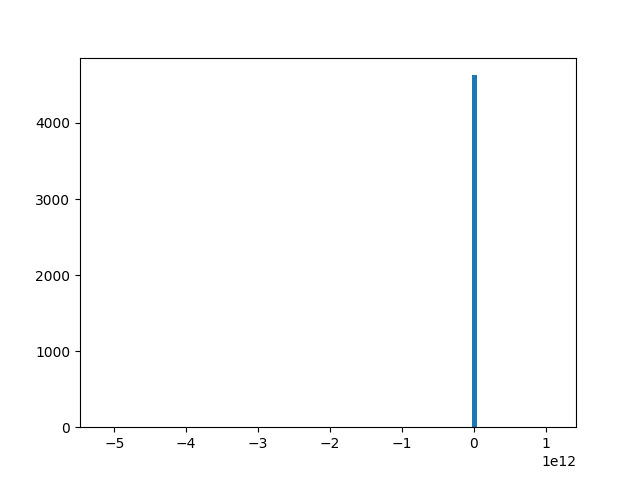

In [24]:
plt.close('all')
plt.figure()
plt.hist(pix_stats['g_sum_pixel_values'].values, bins=100)
plt.show()

In [52]:
pix_stats.loc[pix_stats['u_n_valid_pixels'] < 10.**8]

,tile,bands,u_n_valid_pixels,u_sum_pixel_values,u_sum_pixel_values_squared,u_min,u_max,u_frac_zeros,u_kurtosis,g_n_valid_pixels,...,i_max,i_frac_zeros,i_kurtosis,z_n_valid_pixels,z_sum_pixel_values,z_sum_pixel_values_squared,z_min,z_max,z_frac_zeros,z_kurtosis
